In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from Trans import train_transformer, predict

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [3]:
news_path = "C:/OMSCS/7643/project/data/cryptonews.csv"
df = pd.read_csv(news_path)
## Test with sample data
df = df[:1000]
df.head()

,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [4]:
## Text Data Preprocessing
if 'date' not in df.columns:
    raise ValueError("no 'date' column")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['content'] = (
    "Subject: " +
    df['subject'] + ". " +
    df['title'].fillna('') + ". " +
    df['text'].fillna('')
)
df = df[df['content'].str.strip() != ""]
df = df.reset_index(drop=True)
print("Example content:\n", df['content'].iloc[0])

Example content:
 Subject: altcoin. Grayscale CEO Calls for Simultaneous Approval of Spot Products to Level the Field. Grayscale CEO Michael Sonnenshein believes the SEC needs to approve spot Bitcoin exchange-traded funds (ETFs) simultaneously.


In [5]:
## Finbert embedding
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert").to(device)
model.eval()

def get_cls_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
    return cls_emb

emb_list = []

print("Generating CLS embeddings with subject-aware input…")
for text in tqdm(df['content'], total=len(df)):
    emb = get_cls_embedding(text)
    emb_list.append(emb)

emb_matrix = np.vstack(emb_list)   # (N, 768)


Generating CLS embeddings with subject-aware input…


100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


In [6]:
## Hourly Text Embeddings
emb_cols = [f"emb_{i}" for i in range(768)]
emb_df = pd.DataFrame(emb_matrix, columns=emb_cols)
df_emb = pd.concat([df[['date']].reset_index(drop=True), emb_df], axis=1)
df_emb['date_hour'] = df_emb['date'].dt.floor('H')
hourly_emb = df_emb.groupby('date_hour')[emb_cols].mean().reset_index()
hourly_emb.head()

C:\Users\doshi\AppData\Local\Temp\ipykernel_19696\802918418.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_emb['date_hour'] = df_emb['date'].dt.floor('H')


,date_hour,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,2023-11-29 21:00:00,0.685937,-0.175782,-0.418467,-0.240459,0.002446,-0.415700,0.011930,-0.176397,0.219973,...,-0.369652,0.441412,0.080532,-0.902804,-0.106736,0.595504,-0.001357,0.087299,-0.224498,-0.283307
1,2023-11-29 22:00:00,0.278765,0.488491,-0.353406,-0.647268,-0.173605,-0.571497,0.455086,0.354890,0.820895,...,-0.056297,1.017099,-0.256585,-0.820362,-0.265179,0.054586,-0.207811,-0.440987,-0.222430,0.359706
2,2023-11-29 23:00:00,0.639068,0.175074,-0.526702,-0.020030,0.231029,-0.540888,0.551504,0.032824,0.349928,...,-0.515791,0.268449,0.172254,-1.028745,-0.331740,0.830287,0.295811,-0.612826,-0.298530,0.164764
3,2023-11-30 00:00:00,0.079712,-0.026688,-0.279870,-0.250984,-0.175536,0.266947,0.528508,0.284000,-0.061967,...,-0.230552,0.039375,0.018115,-0.834358,-0.298699,0.371941,0.404163,-0.264449,0.265108,0.275159
4,2023-11-30 01:00:00,1.411578,-0.772031,-0.087204,-0.101453,-0.048951,-0.446711,-0.161336,-0.573305,0.602566,...,-0.217061,0.350743,0.264669,-0.455703,0.596873,0.909731,0.351093,0.408653,0.092464,-0.243826


In [7]:
## Price Data
price_path = r"C:\OMSCS\7643\project\data\data_hourly\BTC_USD_hourly.parquet"
price_df = pd.read_parquet(price_path)
price_df['date_hour'] = pd.to_datetime(price_df['datetime'], errors='coerce').dt.tz_localize(None).dt.floor('H')
price_df = price_df.drop(columns=['datetime'])
price_df.head()

C:\Users\doshi\AppData\Local\Temp\ipykernel_19696\438831854.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df['date_hour'] = pd.to_datetime(price_df['datetime'], errors='coerce').dt.tz_localize(None).dt.floor('H')


,open,high,low,close,date_hour
0,47983.92188,48281.96875,47928.109380,47967.66016,2021-05-15 22:00:00
1,47964.33984,47964.33984,46635.070312,46738.80859,2021-05-15 23:00:00
2,46775.80078,47673.53906,46520.558590,47264.71094,2021-05-16 00:00:00
3,47276.55078,48139.62891,47276.550780,48061.92969,2021-05-16 01:00:00
4,48064.48047,48289.98828,47964.160160,48152.69922,2021-05-16 02:00:00


In [8]:
df = price_df.merge(hourly_emb, on='date_hour', how='inner')
df = df.sort_values('date_hour').reset_index(drop=True)
print("Merged shape:", df.shape)
df['target_close'] = df['close'].shift(-1)
df = df.dropna().reset_index(drop=True)
df.head()

Merged shape: (367, 773)


,open,high,low,close,date_hour,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,target_close
0,37671.56,37788.18,37588.05,37741.85,2023-11-29 21:00:00,0.685937,-0.175782,-0.418467,-0.240459,0.002446,...,0.441412,0.080532,-0.902804,-0.106736,0.595504,-0.001357,0.087299,-0.224498,-0.283307,37797.31
1,37741.84,37845.49,37737.78,37797.31,2023-11-29 22:00:00,0.278765,0.488491,-0.353406,-0.647268,-0.173605,...,1.017099,-0.256585,-0.820362,-0.265179,0.054586,-0.207811,-0.440987,-0.222430,0.359706,37863.84
2,37797.30,37879.29,37731.17,37863.84,2023-11-29 23:00:00,0.639068,0.175074,-0.526702,-0.020030,0.231029,...,0.268449,0.172254,-1.028745,-0.331740,0.830287,0.295811,-0.612826,-0.298530,0.164764,37785.66
3,37864.79,37878.51,37770.20,37785.66,2023-11-30 00:00:00,0.079712,-0.026688,-0.279870,-0.250984,-0.175536,...,0.039375,0.018115,-0.834358,-0.298699,0.371941,0.404163,-0.264449,0.265108,0.275159,37711.29
4,37786.30,37822.08,37703.18,37711.29,2023-11-30 01:00:00,1.411578,-0.772031,-0.087204,-0.101453,-0.048951,...,0.350743,0.264669,-0.455703,0.596873,0.909731,0.351093,0.408653,0.092464,-0.243826,37881.13


In [9]:
price_cols = ['open', 'high', 'low', 'close']
emb_cols = [c for c in df.columns if c.startswith("emb_")]

feature_dim = len(price_cols) + len(emb_cols)
print("feature_dim =", feature_dim)

feature_dim = 772


In [10]:
total_len = len(df)
train_end = int(total_len * 0.7)

train_df = df.iloc[:train_end]
test_df  = df.iloc[train_end:]

sub_end = int(len(train_df) * 0.9)
subtrain_df = train_df.iloc[:sub_end]
val_df      = train_df.iloc[sub_end:]

In [11]:
scaler_price = MinMaxScaler()
scaler_price.fit(subtrain_df[price_cols])

sub_price  = scaler_price.transform(subtrain_df[price_cols])
val_price  = scaler_price.transform(val_df[price_cols])
test_price = scaler_price.transform(test_df[price_cols])

# embedding
sub_emb  = subtrain_df[emb_cols].values * 0.01
val_emb  = val_df[emb_cols].values * 0.01
test_emb = test_df[emb_cols].values * 0.01

# combine
X_sub_df  = np.concatenate([sub_price,  sub_emb],  axis=1)
X_val_df  = np.concatenate([val_price,  val_emb],  axis=1)
X_test_df = np.concatenate([test_price, test_emb], axis=1)

# y scaler
scaler_y = MinMaxScaler()
scaler_y.fit(subtrain_df[['target_close']])

y_sub  = scaler_y.transform(subtrain_df[['target_close']]).reshape(-1)
y_val  = scaler_y.transform(val_df[['target_close']]).reshape(-1)
y_test = scaler_y.transform(test_df[['target_close']]).reshape(-1)


In [12]:
def build_sequences(X_block, y_block, seq_len=12):
    X_list, y_list = [], []

    for i in range(seq_len, len(X_block)):
        X_list.append(X_block[i-seq_len:i])
        y_list.append(y_block[i])

    return np.array(X_list), np.array(y_list)


seq_len = 12

X_sub,  y_sub_seq  = build_sequences(X_sub_df,  y_sub,  seq_len)
X_val,  y_val_seq  = build_sequences(X_val_df,  y_val,  seq_len)
X_test, y_test_seq = build_sequences(X_test_df, y_test, seq_len)

print("Sub:", X_sub.shape, y_sub_seq.shape)
print("Val:", X_val.shape, y_val_seq.shape)
print("Test:", X_test.shape, y_test_seq.shape)


Sub: (218, 12, 772) (218,)
Val: (14, 12, 772) (14,)
Test: (98, 12, 772) (98,)


In [13]:
X_train_all = np.concatenate([X_sub, X_val], axis=0)
y_train_all = np.concatenate([y_sub_seq, y_val_seq], axis=0)


model, train_losses, val_losses = train_transformer(
    X_train_all,
    y_train_all,
    batch_size=32,
    lr=1e-5,
    epochs=30
)

Epoch 01 | Train Loss 1.057218 | Val Loss 0.895650
Epoch 02 | Train Loss 0.917458 | Val Loss 0.751948
Epoch 03 | Train Loss 0.776838 | Val Loss 0.624986
Epoch 04 | Train Loss 0.664582 | Val Loss 0.511652
Epoch 05 | Train Loss 0.563232 | Val Loss 0.412775
Epoch 06 | Train Loss 0.473455 | Val Loss 0.326947
Epoch 07 | Train Loss 0.396241 | Val Loss 0.254584
Epoch 08 | Train Loss 0.326336 | Val Loss 0.194891
Epoch 09 | Train Loss 0.269853 | Val Loss 0.146629
Epoch 10 | Train Loss 0.224849 | Val Loss 0.108824
Epoch 11 | Train Loss 0.188026 | Val Loss 0.079729
Epoch 12 | Train Loss 0.163470 | Val Loss 0.056463
Epoch 13 | Train Loss 0.141338 | Val Loss 0.039970
Epoch 14 | Train Loss 0.126381 | Val Loss 0.028745
Epoch 15 | Train Loss 0.121136 | Val Loss 0.021999
Epoch 16 | Train Loss 0.105733 | Val Loss 0.018310
Epoch 17 | Train Loss 0.103636 | Val Loss 0.016510
Epoch 18 | Train Loss 0.096816 | Val Loss 0.015942
Epoch 19 | Train Loss 0.094567 | Val Loss 0.015920
Epoch 20 | Train Loss 0.092622 

In [14]:
# ---- test prediction ----
pred_norm = predict(model, X_test)           # (N_test,)
pred_price = scaler_y.inverse_transform(pred_norm.reshape(-1, 1)).reshape(-1)

# ---- ground truth ----
y_true_price = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(-1)


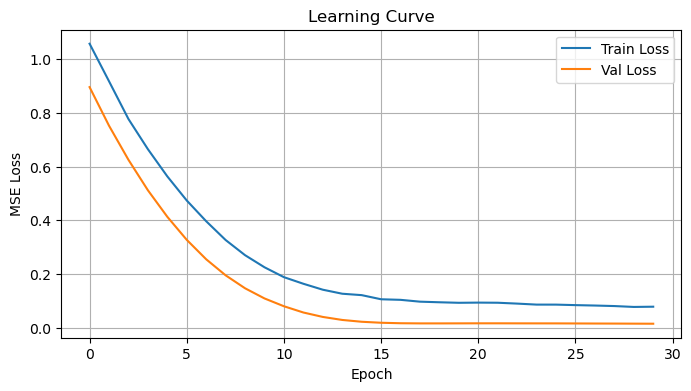

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

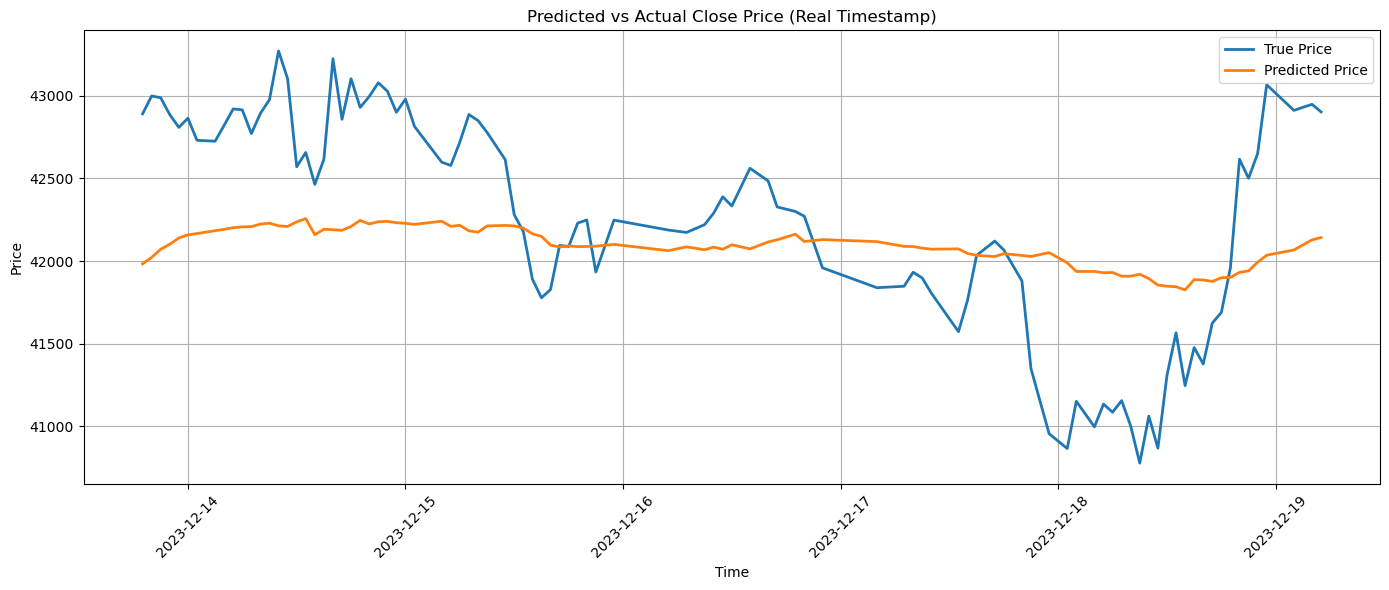

In [16]:
test_timestamps = test_df['date_hour'].values
test_seq_timestamps = test_timestamps[seq_len:]

plt.figure(figsize=(14,6))
plt.plot(test_seq_timestamps, y_true_price, label='True Price', linewidth=2)
plt.plot(test_seq_timestamps, pred_price, label='Predicted Price', linewidth=2)

plt.title("Predicted vs Actual Close Price (Real Timestamp)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse_norm = mean_squared_error(y_test_seq, pred_norm)
mse_real = mean_squared_error(y_true_price, pred_price)

rmse = np.sqrt(mse_real)
mae  = np.mean(np.abs(y_true_price - pred_price))
mape = np.mean(np.abs((y_true_price - pred_price) / y_true_price)) * 100
acc  = 1 - mape/100   # vs paper

print("Normalized MSE:", mse_norm)
print("Real Price MSE:", mse_real)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE(%):", mape)
print("Accuracy:", acc)


Normalized MSE: 0.007476975710615937
Real Price MSE: 360500.9540467929
RMSE: 600.4173165780554
MAE: 513.0286607525511
MAPE(%): 1.2133003916762533
Accuracy: 0.9878669960832375
